<a href="https://colab.research.google.com/github/akhilendra1811/Understanding-Transformers/blob/main/Comparision_of_delta_GClip_vs_Other_Optimisers_on_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing d2l

In [ ]:
!pip install d2l==1.0.3


#Setting Up The Transformer, Data and the Loss

The section numbers hyperlink to the corresponding sections in the book d2l.ai from which this setup is taken.

## Imports

In [ ]:
import math
import torch
from torch import nn
from d2l import torch as d2l

##[11.3.2.1](https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html#masked-softmax-operation) Masked Softmax

In [ ]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

$\text{masked-softmax}(X, \text{valid_lens}) =$<br>
Input:<br>
$ X \in \mathbb R^{N \times D}\\
\text{valid_lens} \in \mathbb N^{N \times 1}$ <br>
 <br><br>
1) $mask \in \mathbb R^{N \times D}, mask_{ij} = \begin{cases} 1 & \text{valid_lens}_i \ge j,\\
0 & \text{otherwise}\end{cases}$<br>
2) $\tilde{X}_{ij} = \begin{cases}
  -10^6 &\text{if }mask_{ij} = 0,\\
  X_{ij}& \mathrm{otherwise}
\end{cases}$ <br>
3) $\mathrm{output} \in \mathbb R^{N \times D}, \mathrm{output}_{ij} = \mathrm{softmax}(\tilde{X}) = [...,\dfrac{e^{\tilde{X}_{ij}}}{\sum_{j=1}^{D} e^{\tilde{X}_{ij}}},...]$

##[11.3.3](https://d2l.ai/chapter_attention-mechanisms-and-transformers/attention-scoring-functions.html#scaled-dot-product-attention) Scaled Dot-product Attention

In [ ]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

$Q' = [Q'_1, Q'_2, ... , Q'_n] \in \mathbb R^{n \times a \times b}\\
K' = [K'_1, K'_2, ... , K'_n] \in \mathbb R^{n \times b \times c}\\
BMM(Q',K') = [Q'_1K'_1, Q'_2K'_2, ... ,Q'_nK'_n] \in \mathbb R^{n \times a \times c}$<br><br>
$DotProductAttention = (\text{softmax}(\dfrac{(QK^\top)}{\sqrt{D}})V) \in \mathbb R^{N \times D}$<br><br>
$DotProductAttention(Q, K, V, \text{valid_lens}) =$<br>
Input: <br>
$Q, K, V \in \mathbb R^{1 \times D}\\
\text{valid_lens} \in \mathbb N$

1) $s \in \mathbb R, s = \dfrac{Q \cdot K^\top}{\sqrt{D}}$<br><br>
2) $m \in \mathbb R, m = \text{masked-softmax}(s, \text{valid_lens})$<br><br>
3) $output \in \mathbb R^{1 \times D}, output = m \cdot V$

##[11.5.](https://d2l.ai/chapter_attention-mechanisms-and-transformers/multihead-attention.html) Multi-headed Attention

In [ ]:
class MultiHeadAttention(d2l.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        test = self.W_q(queries)
        print(queries.shape)
        print(test.shape)
        print(test)
        queries = self.transpose_qkv(test)
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [ ]:
@d2l.add_to_class(MultiHeadAttention)
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    print(X)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    print (output)
    return output

@d2l.add_to_class(MultiHeadAttention)
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
class EasyMultiHeadAttention(d2l.Module):
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [ ]:
@d2l.add_to_class(EasyMultiHeadAttention)
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    print(X)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    output = X.reshape(-1, X.shape[2], X.shape[3])
    print (output)
    return output

@d2l.add_to_class(MultiHeadAttention)
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [ ]:
num_hiddens, num_heads = 20, 2
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.tensor([[[2, 0.737],[3.1, 3]],[[9, 3],[17, 0]]], dtype = torch.float32)
Y = torch.tensor([[[9, 3],[17, 0]],[[9, 3],[17, 0]]], dtype = torch.float32)
attention(X, Y, Y, valid_lens)

torch.Size([2, 2, 2])
torch.Size([2, 2, 20])
tensor([[[  0.4594,  -1.1740,   0.5999,  -1.1110,   0.8986,   0.1323,  -0.3736,
            1.4539,  -0.0821,  -1.5904,  -1.1702,  -0.9564,  -0.7055,  -0.2351,
            0.6955,   1.0288,   1.3692,  -1.1764,  -0.4707,  -1.5811],
         [  0.8331,  -2.3055,  -0.2971,  -2.9264,   0.3768,   0.9733,   0.0429,
            3.4985,  -0.4686,  -3.1183,  -2.9955,  -2.0433,  -1.1901,   0.8197,
            2.0987,   1.9754,   2.5820,  -2.1312,   0.5103,  -3.7332]],

        [[  2.0467,  -5.2002,   2.9085,  -4.7941,   4.2168,   0.4643,  -1.7870,
            6.3305,  -0.3111,  -7.0457,  -5.0647,  -4.2083,  -3.1583,  -1.2597,
            2.9560,   4.5645,   6.0832,  -5.2416,  -2.3296,  -6.8964],
         [  3.4970,  -8.3406,   9.2365,  -5.3815,  11.0646,  -1.4667,  -5.2726,
            8.1602,   0.4537, -11.3162,  -5.9622,  -6.2382,  -5.6710,  -5.9916,
            2.4704,   7.4603,  10.0884,  -8.9621,  -8.1826,  -9.1143]]],
       grad_fn=<UnsafeViewB

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([[[  2.8337,   5.8556,   2.8725,  -5.8189,   6.8610,   2.3877, -11.0519,
           -4.1230,   2.2083,  -5.3208,   8.0694,   5.3220,   5.6198,   0.1843,
            3.2816,   4.3672,   2.2224,   1.4445,   1.5292,  -3.8587],
         [  0.5749,   1.4928,   0.6924,  -1.9685,   1.6546,   0.9466,  -2.9096,
           -1.4981,   0.2566,  -1.6808,   2.1247,   1.1479,   1.7973,  -0.0396,
            0.9702,   1.3114,   0.7256,   0.3453,   0.1458,  -1.2761]],

        [[  6.6996,  -0.3564,  -3.2892,   2.0977,   5.5807,  10.8424,  -6.7173,
            5.8634,  -1.5558,   2.1275,  -3.4551,  -4.6612,  10.1355,   0.4548,
            7.0248,   7.4192,   1.1802, -11.3343,   0.0240,  -5.8854],
         [  6.7330,  -0.2962,  -3.2586,   2.0519,   5.6540,  10.8571,  -6.8281,
            5.8340,  -1.5243,   2.0822,  -3.3741,  -4.6004,  10.1827,   0.4592,
            7.0546,   7.4583,   1.1984, -11.3188,   0.0467,  -5.9166]]],
       grad_fn=<UnsafeViewBackward0>)

Input:<br>
$Q, K, V \in \mathbb R^{N \times D}\\
\text{D}\in \mathbb N, \text{H} \in \mathbb N, \dfrac{\text{D}}{H}\in \mathbb N$<br><br>
1)$\tilde{Q} ,\tilde{K}, \tilde{V}\in \mathbb R^{N\times \text{D}}\\
W^{(q)}, W^{(k)}, W^{(v)} \in \mathbb R^{D \times \text{D}}\\
\tilde{Q} = QW^{(q)}\\
\tilde{K} = KW^{(k)}\\
\tilde{V} = VW^{(v)}$<br><br>
2)$\tilde{Q}_H = [q_1, q_2, ... , q_H] \in \mathbb R^{H \times N \times (D/H)}\\
\tilde{K}_H = [k_1, k_2, ... , k_H] \in \mathbb R^{H \times N \times (D/H)}\\
\tilde{V}_H = [v_1, v_2, ... , v_H] \in \mathbb R^{H \times N \times (D/H)}\\
q, k, v \in \mathbb R^{N \times (D/H)}\\
q_{i(n, d)} = \tilde{Q}_{(n,(d + i(D/H)))}, k_{i(n, d)} = \tilde{K}_{(n,(d + i(D/H)))}, v_{i(n, d)} = \tilde{V}_{(n,(d + i(D/H)))}$<br><br>
3)$\mathrm{output}_H \in \mathbb R^{H \times N\times (D/H)}, \mathrm{output}_i = \mathrm{DotProductAttention}(\tilde{Q}_i,\tilde{K}_i,\tilde{V}_i)$<br><br>
4)$\tilde{\mathrm{output}} \in \mathbb R^{N\times D}, \tilde{\mathrm{output}} = [\mathrm{output}_1 \cdot \mathrm{output}_2 \cdot ... \cdot \mathrm{output}_H]\\
\text{Where }X,Y \in \mathbb R^{n \times d}, X_{(i,j)} \cdot Y_{(i,j)} = [[X_{(1,1)}, X_{(1,2)}, ... ,X_{(1,d)}, Y_{(1,1)}, Y_{(1,2)}, ... ,Y_{(1,d)}], ... ,[X_{(n,1)}, X_{(n,2)}, ... ,X_{(n,d)}, Y_{(n,1)}, Y_{(n,2)}, ... ,Y_{(n,d)}]] \in \mathbb R^{n \times 2d}$<br><br>
5)$W^{(o)} \in \mathbb R^{D\times D}, \mathrm{output} = \tilde{\mathrm{output}}W^{(o)} \in \mathbb R ^{N \times D}$

##[11.6.3](https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html#positional-encoding) Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

$X + P \text{ where }$
\begin{split}\begin{aligned} P_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\P_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}\end{split}

Input : <br>
$X \in \mathbb R^{N \times D}\\
\text{max_len}\in \mathbb N\\
\text{max_len} \ge N$
<br><br>

1)$B \in \mathbb R^{\text{max_len} \times D}\\
B = [[0,0,...],...,[\text{max_len},\text{max_len},...]]$ <br><br>
2)$P_{ij} \in \mathbb R^{\text{max_len} \times D}\\
P_{ij} = [..., \frac{B_i}{10000^{2B_j/D}},...]$ <br><br>
3)$\tilde{P_{ij}} \in \mathbb R^{\text{max_len} \times D}\\
\tilde{P_{ij}} = \begin{cases}
  \sin(P_{ij}) &\text{if }j = even,\\
  \cos(P_{ij}) & \text{otherwise}
\end{cases}$<br><br>
4) $\mathrm{output} \in \mathbb R^{N \times D}\\
\mathrm{output} = X + \tilde{P}_N$

##[11.7.2](https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#positionwise-feed-forward-networks) Positionwise-FFN

In [ ]:
class PositionWiseFFN(nn.Module):
    """The positionwise feed-forward network."""
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

Input: <br>
$X \in \mathbb R^{N \times D}\\
\text{ffn_num_hiddens} \in \mathbb R$<br><br>

$\mathrm{ReLU(X)} = max(0,X)\\
\mathrm{dense1} \in \mathbb R^{D \times \text{ffn_num_hiddens}}\\
\mathrm{dense2} \in \mathbb R^{\text{ffn_num_hiddens} \times D}\\
\mathrm{output} \in \mathbb R^{N \times D}\\
\mathrm{output} = ReLU(Xdense1)dense2$

##[11.7.3](https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#residual-connection-and-layer-normalization) Add and Normalize

In [ ]:
class AddNorm(nn.Module):
    """The residual connection followed by layer normalization."""
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(Y + X)

$\mathrm{LayerNorm}(X_{ij}) = [...,\frac{X_{ij} - \hat{\mu_i}}{\hat{\sigma_i}},...]\\
\hat{\mu_i} = \frac{1}{n}\sum_{ j=1}^{n}X_{ij}\\
\hat{\sigma_i} = \sqrt{\frac{1}{n}\sum_{j=1}^{n}(X_{ij} - \hat{\mu_i})^2 + ϵ}.$<br><br>
Where $\epsilon$ is some small offset > 0 to prevent division by 0 and n is the size of X.



In [ ]:
embedding = nn.Embedding(15,7)
embedding(torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]]))

tensor([[[-0.4905,  1.5497, -0.6045, -0.8807,  1.2257,  1.0852,  0.1970],
         [ 0.3976, -1.5313,  1.6936, -0.8817, -1.7948,  0.1129,  1.7015],
         [ 1.1211, -1.4971,  0.1476, -0.9574, -0.5977, -0.6794, -1.5241],
         [ 1.0737, -0.3604, -0.0350,  0.1741, -1.0322, -0.4690, -1.1333]],

        [[ 1.1211, -1.4971,  0.1476, -0.9574, -0.5977, -0.6794, -1.5241],
         [ 0.3816, -0.7391, -0.5493, -1.5886,  1.6312,  0.5003,  1.1176],
         [ 0.3976, -1.5313,  1.6936, -0.8817, -1.7948,  0.1129,  1.7015],
         [ 0.1275, -0.1214, -0.7450,  0.5422, -0.3595, -0.6162, -1.3314]]],
       grad_fn=<EmbeddingBackward0>)

Input:<br>
$X, Y \in \mathbb R^{N \times D}\\
$<br>
Output:<br>
$\mathrm{LayerNorm}(Y + X )$

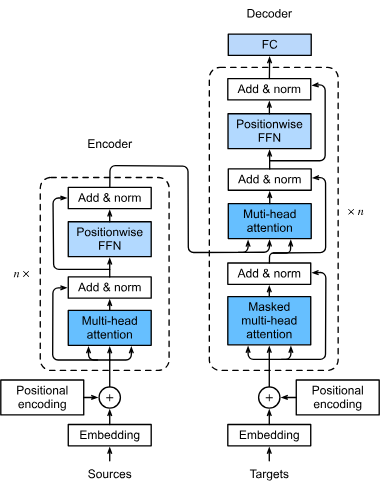

##[11.7.4](https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#encoder) Encoder

$A \in \mathbb R^{N}, B\in \mathbb R^{N \times D}\\
\text{Embed}: A \rightarrow B\\
D \in \mathbb N\\
\text{ffn_num_hiddens} \in \mathbb N\\
H \in \mathbb N\\
\text{num_blks} \in \mathbb N$<br><br>


Input:<br>
$X \in \mathbb R^{N}\\
\text{valid_lens} \in \mathbb N^{N \times 1}$
<br><br>
1)$\mathrm{Embed}(X) \in \mathbb{R}^{N \times D}\\
X_e \in \mathbb{R}^{N \times D}\\
X_e = \mathrm{PositionalEncoding}(\mathrm{Embed}(X) * \sqrt{D})$<br><br>
2)$X_o \in \mathbb R^{N \times D}\\
X_o = \text{Multi-headed_attention}(X_e, X_e, X_e, \text{valid_lens})\\
Y \in \mathbb R^{N \times D}\\
Y = \mathrm{AddNorm}(X, X_o)\\
Y_o \in \mathbb R^{N \times D}\\
Y_o = \mathrm{AddNorm}(Y, \mathrm{PositionWiseFFN}(Y))
$ <br>
Repeat step 2 for $\text{num_blks}$ times, using $Y_o$ as $X_o$ for next iteration.<br><br>


In [ ]:
class TransformerEncoderBlock(nn.Module):
    """The Transformer encoder block."""
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [ ]:
class TransformerEncoder(d2l.Encoder):
    """The Transformer encoder."""
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

##[11.7.5](https://d2l.ai/chapter_attention-mechanisms-and-transformers/transformer.html#decoder) Decoder

$\text{vocab_size} \in \mathbb N$

Input:<br>
$X \in \mathbb{R}^{N \times D}\\
\text{state} = \{\text{enc-outputs}, \text{enc-valid-lens}, \text{dec-states}\}$<br>
Where<br>
$\text{enc-outputs} \in \mathbb{R}^{N \times D}\\
\text{enc-valid-lens} \in \mathbb{N}^{N \times 1}$<br>
and $\text{dec-states}$ is None on the first input.<br><br>

1) $\mathrm{Embed(X)} \in \mathbb{R}^{N \times D}\\
X_e \in \mathbb{R}^{N \times D}, X_e = \mathrm{PositionalEncoding}(\mathrm{Embed}(X) * \sqrt{D})$<br><br>
2) $\text{key-values} \in \mathbb R^{(\text{num-steps}*N)\times D}, \text{key-values} = \begin{cases}X_e &\text{if dec-states = None},\\
\text{Concatenate_1}(\text{state}[2][i], X_e) &\text{otherwise}\end{cases}\\
\text{dec-states} = \text{key-values}\\
\text{dec_valid_lens} \in \mathbb N^{N}, \text{dec_valid_lens} = [1, 2,..., N]\\
X_o \in \mathbb R^{N \times D}, X_o = \text{Multi-headed-attention}(X_e, \text{key-values}, \text{key-values}, \text{dec-valid-lens})\\
Y \in \mathbb R^{N \times D}, Y = \mathrm{AddNorm}(X_e, X_o)\\
Y_o \in \mathbb R^{N \times D}, Y_o = \text{Multi-headed-attention}(Y, \text{enc-outputs}, \text{enc-outputs}, \text{enc-valid-lens})\\
Z \in \mathbb R^{N \times D}, Z = \mathrm{AddNorm}(Y, Y_o)\\
Z_o \in \mathbb R^{N \times D}, Z_o = \mathrm{AddNorm}(Z, PositionWiseFFN(Z))$<br><br>
3) $W \in \mathbb R^{D \times \text{vocab-size}}\\
\mathrm{Output} \in \mathbb R^{N \times \text{vocab-size}}, Output = Z_oW$

Repeat step 2 for $\text{num-blks}$ times, keeping $\text{dec-states}$ and using $Z_o$ as $X_e$

In [ ]:
class TransformerDecoderBlock(nn.Module):
    # The i-th block in the Transformer decoder
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so state[2][self.i] is None as initialized. When
        # decoding any output sequence token by token during prediction,
        # state[2][self.i] contains representations of the decoded output at
        # the i-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of dec_valid_lens: (batch_size, num_steps), where every
            # row is [1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of enc_outputs:
        # (batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [ ]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## Transformer Output


$D \in \mathbb N, H\in \mathbb N, D/H \in \mathbb N\\
\text{vocab_size} \in \mathbb N\\
X_{\rm tgt} \in \mathbb R^{D}, X_{\rm scr} \in \mathbb R^D\\
\mathbb R^{N\times \text{vocab-size}} \ni \hat{Y} = {\rm Decoder}(X_{\rm tgt}, {\rm Encoder}(X_{\rm src}))$

#Defining Different Optimizers

Number of Training Data: $2048$

Number of Validation Data: $256$

Batch Size: $128$

In [ ]:
def calculate_average_bleu(model, src, tgt, data):
    preds, _ = model.predict_step(
        data.build(src, tgt), d2l.try_gpu(), data.num_steps)

    total_bleu_score = 0
    for en, fr, p in zip(src, tgt, preds):
        translation = []
        for token in data.tgt_vocab.to_tokens(p):
            if token == '<eos>':
                break
            translation.append(token)
        total_bleu_score += d2l.bleu(" ".join(translation), fr, k=2)

    average_bleu_score = total_bleu_score / len(preds)
    return average_bleu_score

data = d2l.MTFraEng(batch_size=128, num_train=2048, num_val=256)
src, tgt = data._tokenize(data._preprocess(data._download()))
engs = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in src]
fras = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in tgt]

##ADAM

Adam Update Formula:

First moment:

$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g(\theta_{t})$

Second moment:

$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g(\theta_{t})^2$

Bias-corrected first moment estimate:

$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$

Bias-corrected second moment estimate:

$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$

Update:

$\theta_{t+1} = \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$


In [ ]:
import time
import numpy as np
data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

class Seq2Seq(d2l.EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()



    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)


class MyTrainer(d2l.Trainer):
  def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0, num_trials=5):
        super().__init__(max_epochs=max_epochs, num_gpus=num_gpus, gradient_clip_val=gradient_clip_val)
        self.num_trials = num_trials
        self.all_train_losses = []
        self.all_val_losses = []

  def fit_epoch(self):
        self.model.train()
        total_train_loss = 0
        num_train_batches = 0
        for batch in self.train_dataloader:
            losstrain = self.model.training_step(self.prepare_batch(batch))
            total_train_loss += losstrain.item()
            num_train_batches += 1
            self.optim.zero_grad()
            with torch.no_grad():
                losstrain.backward()
                if self.gradient_clip_val > 0:  # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        average_train_loss = total_train_loss / num_train_batches
        self.train_losses.append(average_train_loss)
        if self.val_dataloader is None:
            return
        self.model.eval()
        total_val_loss = 0
        num_val_batches = 0
        for batch in self.val_dataloader:
            with torch.no_grad():
                lossval = self.model.validation_step(self.prepare_batch(batch))
                total_val_loss += lossval.item()
                num_val_batches += 1
            self.val_batch_idx += 1
        average_val_loss = total_val_loss / num_val_batches
        self.val_losses.append(average_val_loss)

  def fit(self, data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, modelname, lr):
    total_bleu_scores = 0
    for trial in range(self.num_trials):
        encoder = TransformerEncoder(
          len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout)
        decoder = TransformerDecoder(
          len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout)
        model = modelname(encoder, decoder, data.tgt_vocab['<pad>'],
                    lr)
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        self.train_losses = []
        self.val_losses = []
        self.epoch = 0
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
        self.all_train_losses.append(self.train_losses)
        self.all_val_losses.append(self.val_losses)
        total_bleu_scores += calculate_average_bleu(model, engs, fras, data)
    average_bleu_scores = total_bleu_scores/self.num_trials
    return model, average_bleu_scores
# Initialize trainer with multiple trials
ADAMtrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=5)
ADAMmodel, ADAMbleu = ADAMtrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2Seq, lr=0.001)

##ADAMW (with weight_decay = 0.01)

AdamW update formula:

First moment:

$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g(\theta_t)$

Second moment:

$v_t = \beta_2 v_{t-1} + (1 - \beta_2) (g(\theta_t))^2$

Bias-corrected first moment estimate:

$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$

Bias-corrected second moment estimate

$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$

Update

$\theta_{t+1} = \theta_t - \eta \left( \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} + \lambda \theta_t \right)$

In [ ]:
data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

class Seq2SeqADAMW(d2l.Seq2Seq):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l
    def configure_optimizers(self):
        # SGD optimizer is used here
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.01)

ADAMWtrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=5)
ADAMWmodel, ADAMWbleu = ADAMWtrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2SeqADAMW, lr=0.001)

##delta-GClip

$h(\theta_t) = \eta \min\left\{1, \max\left\{\delta, \frac{\gamma}{\|g(\theta_t)\|}\right\}\right\}$

$\theta_{t+1} = \theta_t - h(\theta_t) \cdot g(\theta_t)$

In [ ]:
from torch.optim import Optimizer
data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)

class deltaGClipOptimizer(Optimizer):
    def __init__(self, params, lr=0.1, delta=1e-03, gamma=0.25):
        defaults = dict(lr=lr, delta=delta, gamma=gamma)
        super(deltaGClipOptimizer, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        for group in self.param_groups:
            delta = group['delta']
            gamma = group['gamma']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                norm = grad.norm()
                if norm != 0 and not torch.isnan(norm):
                    g_norm = min(1, max(delta, gamma / norm))
                    scaled_grad = g_norm * grad
                    p.data -= lr * scaled_grad

class Seq2Seqdelta(d2l.Seq2Seq):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l

    def configure_optimizers(self):
        # SGD optimizer is used here
        return deltaGClipOptimizer(self.parameters(), lr=self.lr, delta=1e-03, gamma=1)


deltaGCliptrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=5)
deltaGClipmodel, deltaGClipbleu = deltaGCliptrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2Seqdelta, lr=0.5)

##Gradient Clipping  (delta-GClip with delta = 0)





In [ ]:
from torch.optim import Optimizer
data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4

class GClipOptimizer(Optimizer):
    def __init__(self, params, lr=0.1, delta=0, gamma=0.1):
        defaults = dict(lr=lr, delta=delta, gamma=gamma)
        super(GClipOptimizer, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""
        for group in self.param_groups:
            delta = group['delta']
            gamma = group['gamma']
            lr = group['lr']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                norm = grad.norm()
                if norm != 0 and not torch.isnan(norm):
                    g_norm = min(1,  (gamma / norm))
                    scaled_grad = g_norm * grad
                    p.data -= lr * scaled_grad

class Seq2SeqGClip(d2l.Seq2Seq):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l

    def configure_optimizers(self):
        # SGD optimizer is used here
        return GClipOptimizer(self.parameters(), lr=self.lr, delta=0, gamma=1)


GCliptrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=1)
GClipmodel, GClipbleu = GCliptrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2SeqGClip, lr=0.5)

##SGD

SGD Update Formula:

Parameter update:

$ \theta_{t+1} = \theta_t - \eta g(\theta_t, x_i, y_i) $

Where:
- $ \theta_t $ represents the parameter vector at iteration $ t $.
- $ \eta $ is the learning rate, a hyperparameter that determines the step size at each iteration while moving toward a minimum of a loss function.
- $ g(\theta_t, x_i, y_i) $ denotes the gradient of the loss function with respect to the parameters $ \theta $ for a single data point $ (x_i, y_i) $.


In [ ]:
import time
data = d2l.MTFraEng(batch_size=128, num_train=512, num_val=256)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
class Seq2SeqSGD(d2l.EncoderDecoder):
    """The RNN encoder--decoder for sequence to sequence learning.

    Defined in :numref:`sec_seq2seq_decoder`"""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        #self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        return self.loss(Y_hat, batch[-1])

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        #self.plot('loss', l, train=True)
        return l

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

SGDtrainer = MyTrainer(max_epochs=50, gradient_clip_val=1, num_gpus=1, num_trials=1)
SGDmodel, SGDbleu = SGDtrainer.fit(data, num_hiddens, ffn_num_hiddens, num_heads,
          num_blks, dropout, Seq2SeqSGD, lr=0.5)



#Comparative Plots : ADAM vs ADAMW vs delta-GClip

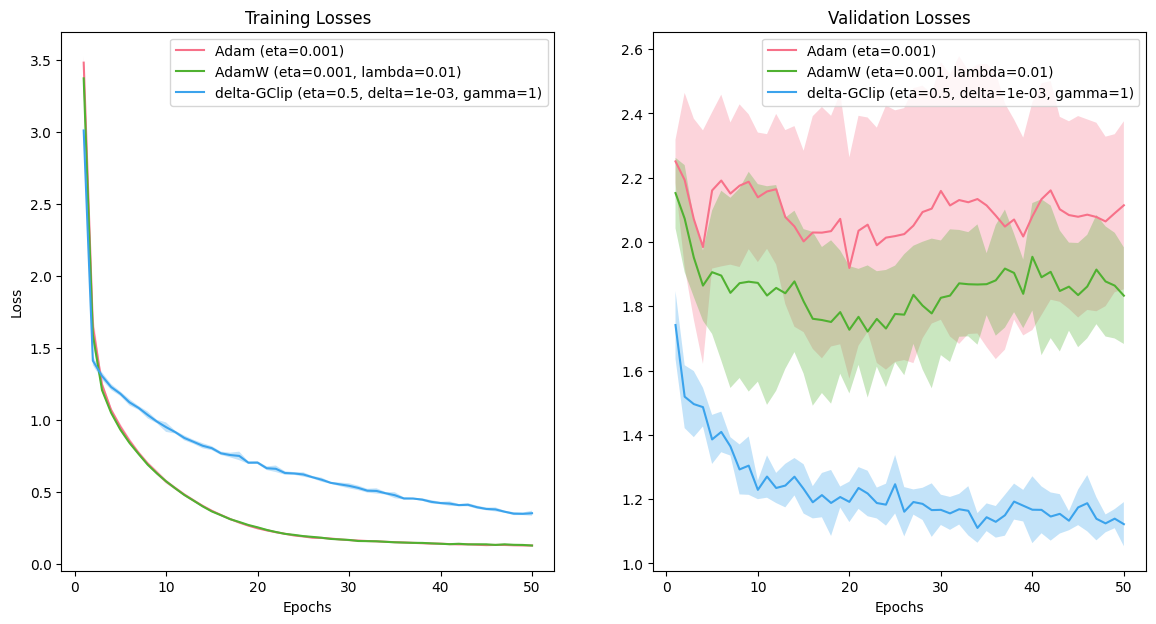

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_losses_with_shaded_errors(train_data, val_data, labels):
    epochs = range(1, len(train_data[0][0]) + 1)  # Assuming all data have the same number of epochs
    clrs = sns.color_palette("husl", len(labels))  # Generate distinct colors for each label

    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=False)

    # Plot training losses with shaded error bars
    for (train_mean, train_std), color, label in zip(train_data, clrs, labels):
        ax[0].plot(epochs, train_mean, label=label, color=color)
        ax[0].fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.3, facecolor=color)
    ax[0].set_title('Training Losses')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='upper right')

    # Plot validation losses with shaded error bars
    for (val_mean, val_std), color, label in zip(val_data, clrs, labels):
        ax[1].plot(epochs, val_mean, label=label, color=color)
        ax[1].fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.3, facecolor=color)
    ax[1].set_title('Validation Losses')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(loc='upper right')

    plt.show()

ADAM_train_losses_mean = np.mean(ADAMtrainer.all_train_losses, axis=0)
ADAM_train_losses_std = np.std(ADAMtrainer.all_train_losses, axis=0)
ADAM_val_losses_mean = np.mean(ADAMtrainer.all_val_losses, axis=0)
ADAM_val_losses_std = np.std(ADAMtrainer.all_val_losses, axis=0)

ADAMW_train_losses_mean = np.mean(ADAMWtrainer.all_train_losses, axis=0)
ADAMW_train_losses_std = np.std(ADAMWtrainer.all_train_losses, axis=0)
ADAMW_val_losses_mean = np.mean(ADAMWtrainer.all_val_losses, axis=0)
ADAMW_val_losses_std = np.std(ADAMWtrainer.all_val_losses, axis=0)

deltaGClip_train_losses_mean = np.mean(deltaGCliptrainer.all_train_losses, axis=0)
deltaGClip_train_losses_std = np.std(deltaGCliptrainer.all_train_losses, axis=0)
deltaGClip_val_losses_mean = np.mean(deltaGCliptrainer.all_val_losses, axis=0)
deltaGClip_val_losses_std = np.std(deltaGCliptrainer.all_val_losses, axis=0)

train_data = [
    (ADAM_train_losses_mean, ADAM_train_losses_std),
    (ADAMW_train_losses_mean, ADAMW_train_losses_std),
    (deltaGClip_train_losses_mean, deltaGClip_train_losses_std)
]
val_data = [
    (ADAM_val_losses_mean, ADAM_val_losses_std),
    (ADAMW_val_losses_mean, ADAMW_val_losses_std),
    (deltaGClip_val_losses_mean, deltaGClip_val_losses_std)
]

labels = ['Adam (eta=0.001)', 'AdamW (eta=0.001, lambda=0.01)', 'delta-GClip (eta=0.5, delta=1e-03, gamma=1)']

# Plot
plot_losses_with_shaded_errors(train_data, val_data, labels)

**Note: The $\eta$ chosen for ADAM and ADAMW are the ones found to be optimal for them as per our tests.**

#Comparative Plots : delta-GClip vs SGD vs Gradient Clipping

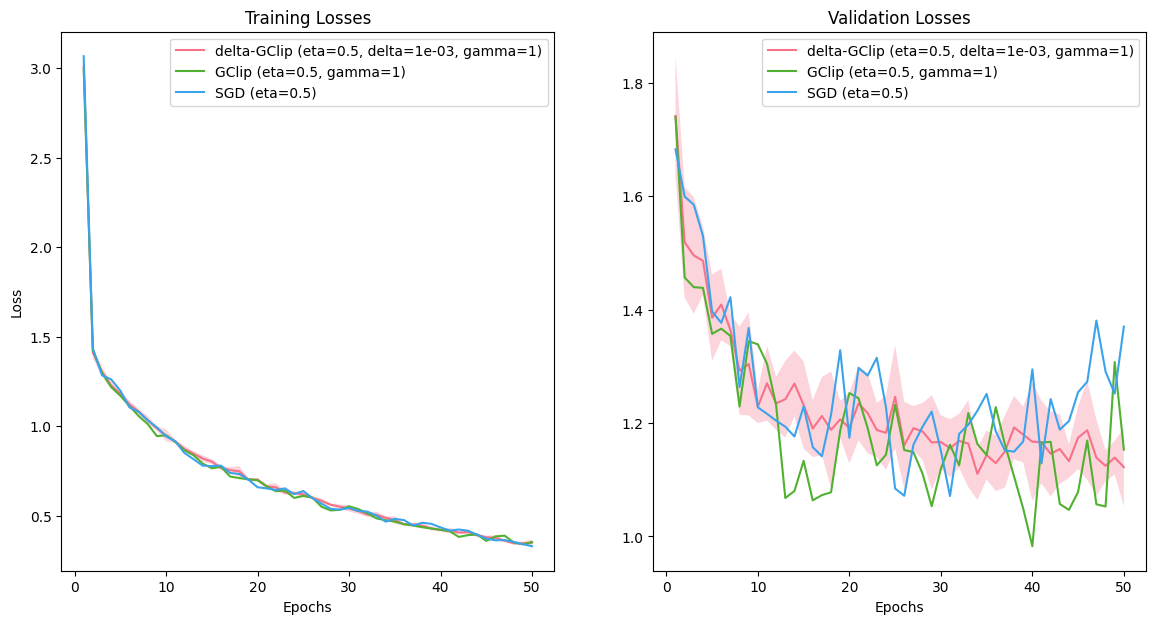

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_losses_with_shaded_errors(train_data, val_data, labels):
    epochs = range(1, len(train_data[0][0]) + 1)  # Assuming all data have the same number of epochs
    clrs = sns.color_palette("husl", len(labels))  # Generate distinct colors for each label

    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=False)

    # Plot training losses with shaded error bars
    for (train_mean, train_std), color, label in zip(train_data, clrs, labels):
        ax[0].plot(epochs, train_mean, label=label, color=color)
        ax[0].fill_between(epochs, train_mean - train_std, train_mean + train_std, alpha=0.3, facecolor=color)
    ax[0].set_title('Training Losses')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='upper right')

    # Plot validation losses with shaded error bars
    for (val_mean, val_std), color, label in zip(val_data, clrs, labels):
        ax[1].plot(epochs, val_mean, label=label, color=color)
        ax[1].fill_between(epochs, val_mean - val_std, val_mean + val_std, alpha=0.3, facecolor=color)
    ax[1].set_title('Validation Losses')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(loc='upper right')

    plt.show()


deltaGClip_train_losses_mean = np.mean(deltaGCliptrainer.all_train_losses, axis=0)
deltaGClip_train_losses_std = np.std(deltaGCliptrainer.all_train_losses, axis=0)
deltaGClip_val_losses_mean = np.mean(deltaGCliptrainer.all_val_losses, axis=0)
deltaGClip_val_losses_std = np.std(deltaGCliptrainer.all_val_losses, axis=0)

GClip_train_losses_mean = np.mean(GCliptrainer.all_train_losses, axis=0)
GClip_train_losses_std = np.std(GCliptrainer.all_train_losses, axis=0)
GClip_val_losses_mean = np.mean(GCliptrainer.all_val_losses, axis=0)
GClip_val_losses_std = np.std(GCliptrainer.all_val_losses, axis=0)

SGD_train_losses_mean = np.mean(SGDtrainer.all_train_losses, axis=0)
SGD_train_losses_std = np.std(SGDtrainer.all_train_losses, axis=0)
SGD_val_losses_mean = np.mean(SGDtrainer.all_val_losses, axis=0)
SGD_val_losses_std = np.std(SGDtrainer.all_val_losses, axis=0)

train_data = [
    (deltaGClip_train_losses_mean, deltaGClip_train_losses_std),
    (GClip_train_losses_mean, GClip_train_losses_std),
    (SGD_train_losses_mean, SGD_train_losses_std)
]
val_data = [
    (deltaGClip_val_losses_mean, deltaGClip_val_losses_std),
    (GClip_val_losses_mean, GClip_val_losses_std),
    (SGD_val_losses_mean, SGD_val_losses_std)
]

labels = ['delta-GClip (eta=0.5, delta=1e-03, gamma=1)', 'GClip (eta=0.5, gamma=1)', 'SGD (eta=0.5)']

# Plot
plot_losses_with_shaded_errors(train_data, val_data, labels)

#Comparing BLEU Scores Across Different Algorithms

In [ ]:



src, tgt = data._tokenize(data._preprocess(data._download()))
engs = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in src]
fras = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in tgt]
preds, _ = ADAMmodel.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)


for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    #print(f'{en} => {translation}, bleu, {d2l.bleu(" ".join(translation), fr, k=2):.3f}')




In [ ]:
src, tgt = data._tokenize(data._preprocess(data._download()))
engs = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in src]
fras = [" ".join(sentence[:-1]).replace("'", "\'") for sentence in tgt]
preds, _ = ADAMmodel.predict_step(
#Change model here ^ model names = (ADAMWmodel, ADAMmodel, ADAM2model, deltaGClipmodel)
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)

total_bleu_score = 0

for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    total_bleu_score += d2l.bleu(" ".join(translation), fr, k=2)
average_bleu_score = total_bleu_score / len(preds)

# Print out the average BLEU score
print(f'Average BLEU score: {average_bleu_score:.3f}')

Average BLEU score: 0.352


In [ ]:
print(ADAMbleu)
print(ADAMWbleu)
print(SGDbleu)
print(deltaGClipbleu)
print(GClipbleu)

0.35146709880141086
0.3474887297330719
0.2633762614190669
0.24211728562115936
0.21071203071584704


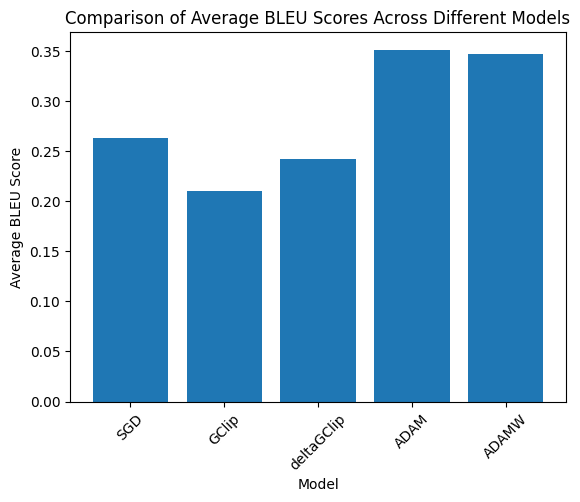

In [ ]:
average_bleu_scores = {
    'SGD' : SGDbleu,
    'GClip' : GClipbleu,
    'deltaGClip': deltaGClipbleu,
    'ADAM': ADAMbleu,
    'ADAMW': ADAMWbleu


}

# Plot the average BLEU scores
plt.bar(range(len(average_bleu_scores)), list(average_bleu_scores.values()), align='center')
plt.xticks(range(len(average_bleu_scores)), list(average_bleu_scores.keys()), rotation=45)
plt.xlabel('Model')
plt.ylabel('Average BLEU Score')
plt.title('Comparison of Average BLEU Scores Across Different Models')
plt.show()
